# Building Apertures?

In [1]:
import lamatrix
import pandorapsf as pp
import pandorasat as ps
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

Let's load the PRF

In [2]:
prf = pp.PRF.from_file("nirda", "pandora_nir_prf.fits", extrapolate=True)

Let's load the scene

In [13]:
pts = pp.PixelTraceScene(np.asarray([[260, 40]]), psf=prf)

In [4]:
nirda = ps.NIRDetector()

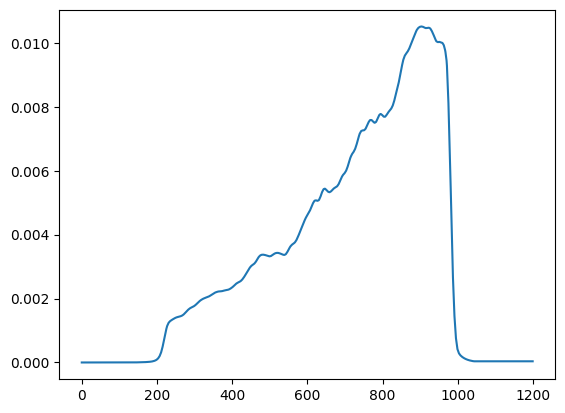

In [5]:
plt.plot(prf.trace_sensitivity)

In [66]:
def model(self, flux, delta_pos = None,
        quiet: bool = False,
        downsample: bool = False,
    ):
        """`spectra` must have shape nwav x ntargets x ntime"""
        flux = np.atleast_1d(flux)
        if flux.ndim == 1:
            flux = flux[:, None]
        elif flux.ndim != 2:
            raise ValueError("Pass a 2D array for flux (ntargets, ntime).")
        if (flux.shape[0] != len(self)):
            raise ValueError("`flux` must have shape (ntargets, ntime)")
        if delta_pos is not None:
            delta_pos = deepcopy(delta_pos) * float(self.scale)
            if delta_pos.ndim == 1:
                delta_pos = delta_pos[:, None]
            elif delta_pos.ndim != 2:
                raise ValueError("Pass 2D array for delta_pos (2, ntime).")

        s = np.interp(pts.pixel.value, pts.psf.trace_pixel.value, pts.psf.trace_sensitivity.value) * pts.psf.trace_sensitivity.unit
        spectra = s[:, None, None] * flux[None, :, :]
        ar = self._get_ar(flux=np.vstack(spectra) * u.pixel, delta_pos=delta_pos, quiet=quiet)

        if self.scale == 1:
            return ar
        if downsample:
            return downsample_array(ar, self.scale)
        else:
            return ar


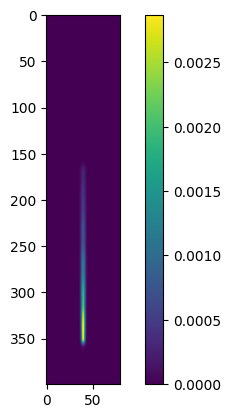

In [74]:
plt.imshow(model(pts, 1*u.electron/u.s)[0].value)
plt.colorbar()

This scene can be used to model in the pixel space. Here are some example images if we just dot the model with a column of ones

Now we have a PRF we want to create something like an aperture for our source. Remember that sources are dispersed so the concept of an aperture is a little different to how we would usually think of one.

For each target, when we create an aperture we want to be able to do something like this

```python
def aperture(tracescene, pandoramag, ...):
    ...
    # create boolean aperture size 400x80
    return aperture
```

So that we can create an estimated aperture from a catalogue of sources. This won't account for redder vs bluer stars having different spectral traces, but that's ok.

Let's decide on a target for our aperture. I've picked a sun-like star

In [151]:
import pandorasat as ps
wav, sed = ps.phoenix.get_phoenix_model(teff=5777, vmag=12)

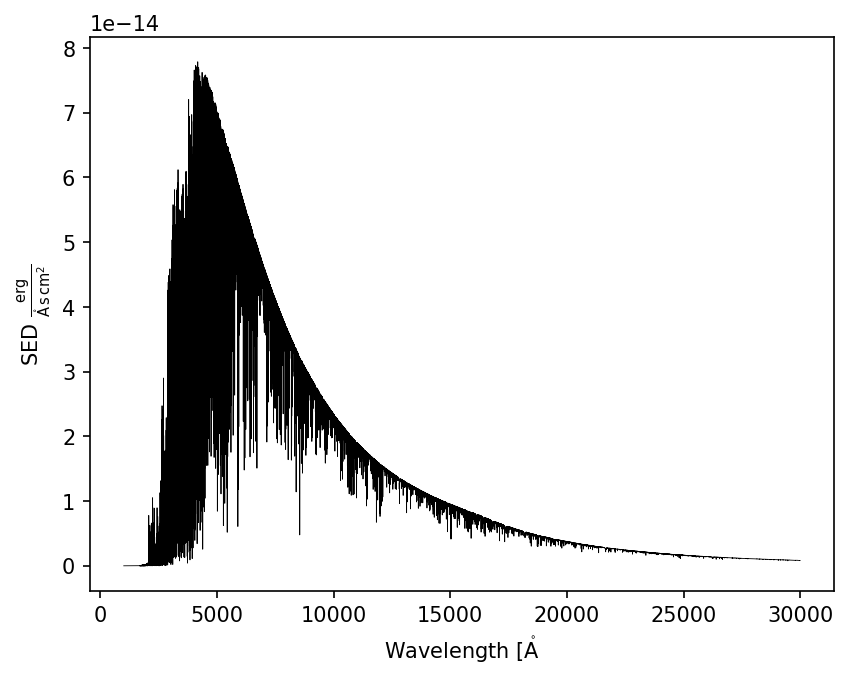

In [152]:
fig, ax = plt.subplots(dpi=150)
ax.plot(wav, sed, c='k', lw=0.4)
ax.set(xlabel=f"Wavelength [{wav.unit.to_string('latex')}", ylabel=f"SED {sed.unit.to_string('latex')}");

We need a way to calculate a Pandora magnitude. We can do that with `pandora-sat`!

**Note this should have the most up to date version of the sensitivity from `pandora-ref`! Make sure your versions are up to date if you try this for real.**

In [153]:
import pandorasat as ps

In [154]:
nirda = ps.NIRDetector()

Let's calculate how much flux we receive from the target

In [155]:
flux = np.trapz((sed * nirda.reference.get_sensitivity(wav)), wav)
flux 

<Quantity 61317.2062487 electron / s>

We can then convert this flux into the Pandora magnitude

In [156]:
nirda.flux_to_mag(flux)

<Quantity 10.86603016>

Note that this is very tightly correlated with the j magnitude of the source. **If you do not have the computational bandwidth to calculate a Pandora magnitude, you can simply use the 2MASS j magnitude.**

We need to pick a position that we assume the target is at. For now we'll assume the target is at this pixel position in the subarray

In [157]:
pos = (260, 40)  # (Row, Column)

In [158]:
# jmags = [10]
# teffs = np.arange(3000, 10000, 500)
# pandoramags = np.zeros((len(jmags), len(teffs)))
# for idx, jmag in enumerate(jmags):
#     for jdx, teff in enumerate(teffs):
#         wav, sed = ps.phoenix.get_phoenix_model(teff=teff, jmag=jmag)
#         flux = np.trapz((sed * nirda.reference.get_sensitivity(wav)), wav)
#         pandoramags[idx, jdx] = nirda.flux_to_mag(flux)
# for jdx in range(len(jmags)):
#     plt.plot(teffs, pandoramags[jdx], c=f"C{jdx}");
#     plt.axhline(jmags[jdx], ls='--', c=f"C{jdx}");

In [214]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd

In [215]:
hdulist = fits.open("/Users/chedges/Pandora/repos/pandora-ref/src/pandoraref/data/nirda/spectrum_normalization.fits")

In [256]:
df = Table(hdulist[1].data).to_pandas()
p, s = df['Pixel'].values * u.Unit(hdulist[1].header['TUNIT1']), df['Sensitivity Per Pixel'].values* u.Unit(hdulist[1].header['TUNIT3'])

s = np.interp((pts.pixel.value), p.value, s.value) * u.Unit(hdulist[1].header['TUNIT3'])
p = (pts.pixel.value + pos[0]) * u.pixel
# w = np.interp((np.arange(400) - 260),  df['Pixel'].values, df['Wavelength'].values) * u.Unit(hdulist[1].header['TUNIT2'])

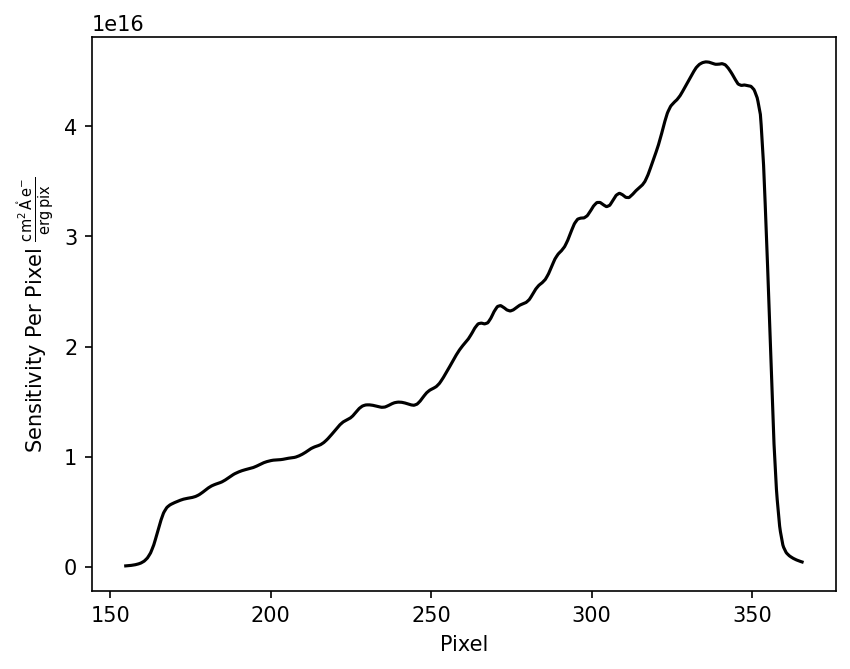

In [257]:
fig, ax = plt.subplots(dpi=150)
ax.plot(p, s, c='k')
ax.set(xlabel='Pixel', ylabel=f"Sensitivity Per Pixel {s.unit.to_string('latex')}");

In [258]:
flux

<Quantity 61317.2062487 electron / s>

In [259]:
flux / np.trapz(s, p)

<Quantity 1.40857869e-14 erg / (Angstrom s cm2)>

In [260]:
flux * s / np.trapz(s, p)

<Quantity [  1.21343684,   1.29111345,   1.36879006,   1.44646666,
             1.54739222,   1.65820672,   1.76902123,   1.87983574,
             2.02564355,   2.1863358 ,   2.34702804,   2.50772028,
             2.7245901 ,   2.96535507,   3.20612005,   3.44688502,
             3.78262489,   4.15876238,   4.53489987,   4.91103735,
             5.45466173,   6.06952672,   6.68439172,   7.29925672,
             8.2060589 ,   9.23702483,  10.26799076,  11.29895669,
            12.79761982,  14.49519917,  16.19277852,  17.89035787,
            20.26035984,  22.91634976,  25.57233968,  28.2283296 ,
            31.50442885,  35.04426668,  38.58410451,  42.12394235,
            45.75886155,  49.43421979,  53.10957804,  56.78493628,
            59.90040911,  62.77775717,  65.65510523,  68.53245329,
            70.55494263,  72.21385217,  73.8727617 ,  75.53167124,
            76.60795694,  77.43644701,  78.26493707,  79.09342714,
            79.70948498,  80.23519331,  80.76090164,  81.28660

In [263]:
im = pts.model(flux * s / np.trapz(s, p))[0]

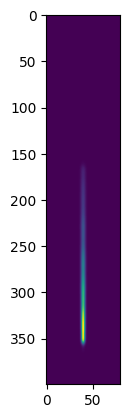

In [265]:
plt.imshow(im.value)

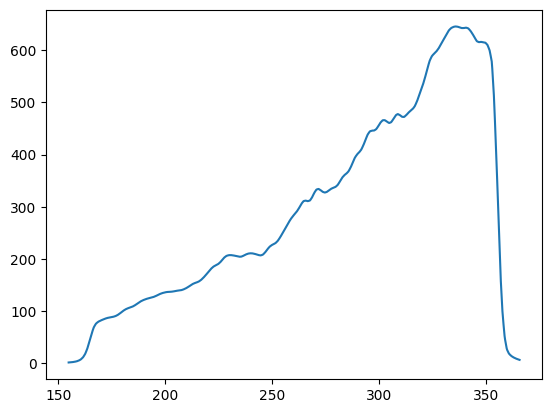

In [261]:
plt.plot(p, flux * s / np.trapz(s, p))

<Quantity [0.84852041, 0.84942104, 0.85032436, 0.85123034, 0.85213902,
           0.8530504 , 0.85396463, 0.85488183, 0.85580171, 0.85672436,
           0.8576498 , 0.85857806, 0.85950911, 0.86044296, 0.86137965,
           0.86231919, 0.8632616 , 0.86420692, 0.86515509, 0.86610616,
           0.86706017, 0.86801708, 0.86897708, 0.86994004, 0.87090597,
           0.87187487, 0.87284679, 0.87382171, 0.87479961, 0.87578056,
           0.87676455, 0.87775167, 0.87874182, 0.87973505, 0.88073137,
           0.88173086, 0.88273344, 0.88373914, 0.88474803, 0.88576007,
           0.88677532, 0.88779377, 0.8888154 , 0.88984027, 0.89086834,
           0.89189975, 0.89293436, 0.89397223, 0.89501345, 0.89605813,
           0.89710604, 0.89815732, 0.89921194, 0.90026996, 0.90133136,
           0.90239612, 0.90346427, 0.90453585, 0.9056109 , 0.90668937,
           0.90777127, 0.90885664, 0.90994556, 0.91103799, 0.91213414,
           0.91323379, 0.91433701, 0.91544379, 0.91655411, 0.91766801,
      

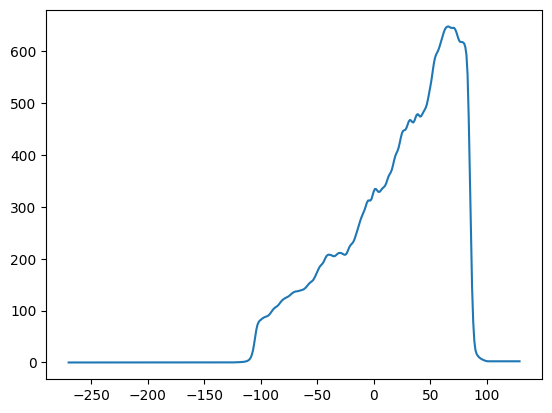

In [212]:
s = np.interp(pts.pixel.value, df['Pixel'].values, df['Sensitivity Per Pixel'].values) * u.Unit(hdulist[1].header["TUNIT3"])
sens = np.interp(wav.to(u.micron).value, df['Wavelength'].values, df['Sensitivity Per Wavelength'].values) * u.Unit(hdulist[1].header["TUNIT4"])
w = np.interp((np.arange(400) - 260),  df['Pixel'].values, df['Wavelength'].values)
s = np.interp((np.arange(400) - 260), df['Pixel'].values, df['Sensitivity Per Pixel'].values) * u.Unit(hdulist[1].header["TUNIT3"])
l = np.trapz(sed * sens/np.trapz(sens, wav), wav) #* nirda.frame_time((400, 80))

# plt.plot(np.arange(400) - 270, (data * aper).sum(axis=1))
plt.plot(np.arange(400) - 270, l * s)

In [228]:
s = np.interp(pts.pixel.value - 1, df['Pixel'].values, df['Sensitivity Per Pixel'].values) * u.Unit(hdulist[1].header["TUNIT3"])

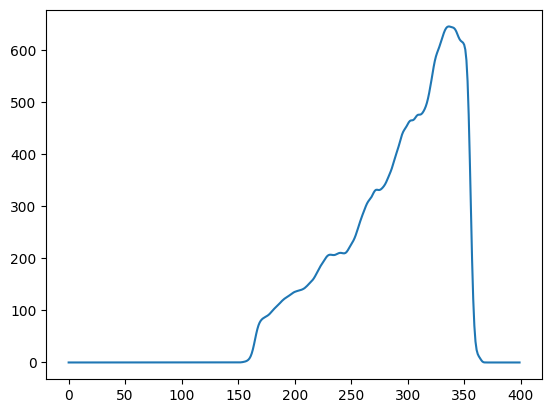

In [229]:
# plt.plot((data * aper).sum(axis=1))
plt.plot(pts.X.dot(l * s).sum(axis=1))

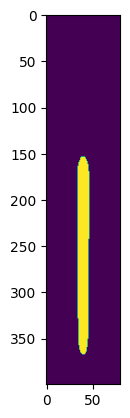

In [89]:
plt.imshow(pts.X.dot(l * s * nirda.frame_time((400, 80))) > 1)

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_89453/1795878975.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(w, (data * aper).sum(axis=1)/pts.X.dot(s).sum(axis=1))


(0.0, 1e-12)

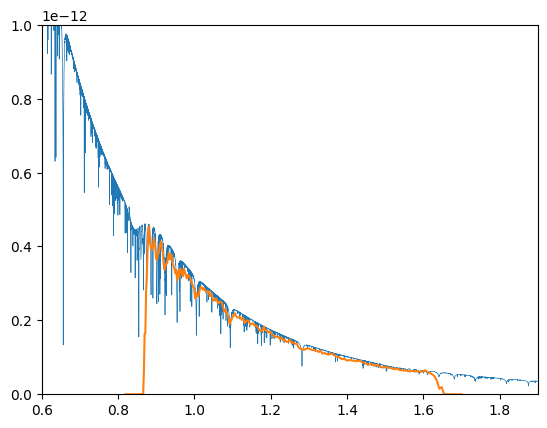

In [65]:
plt.plot(wav.to(u.micron), sed * nirda.frame_time((400, 80)), lw=0.5)
plt.plot(w, (data * aper).sum(axis=1)/pts.X.dot(s).sum(axis=1))
plt.xlim(0.6, 1.9)
plt.ylim(0, 1e-12)

In [43]:
from scipy import sparse
from scipy.linalg import cho_factor, cho_solve

In [44]:
X = pts.X.tocsr()
x = pts.pixel.value

In [45]:
def make_K(x, sigma_w, ell):
    """Squared exponential covariance for weights."""
    dist = x[:, None] - x[None, :]
    return sigma_w**2 * np.exp(-0.5 * (dist / ell)**2)

In [46]:
prior_mu = np.zeros(X.shape[1])
K = make_K(x, 30, 0.1)
cK = cho_factor(K, lower=True)
Kinv = sparse.csr_matrix(cho_solve(cK, np.eye(K.shape[0])))

sigma_w_inv = X.T.dot(X) + Kinv
B = (sparse.csr_matrix(X.T.dot(data.ravel())) + sparse.csr_matrix(Kinv.dot(prior_mu))).T

In [47]:
w = sparse.linalg.spsolve(sigma_w_inv, B)

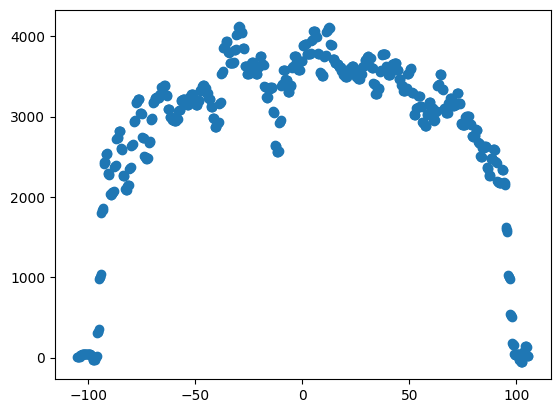

In [48]:
plt.scatter(x, w)

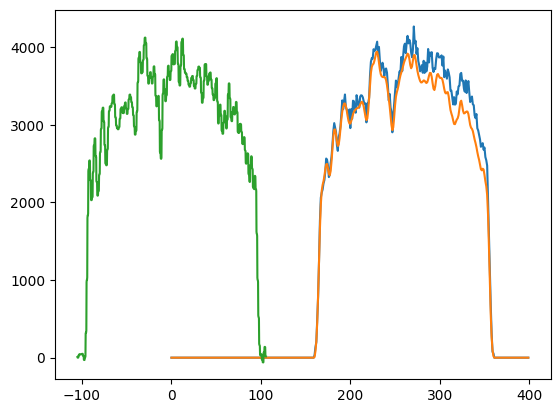

In [49]:
plt.plot(np.arange(data.shape[0]), (data * aper).sum(axis=1))
plt.plot((X.dot(w).reshape(data.shape) * aper).sum(axis=1))
plt.plot(x, w)

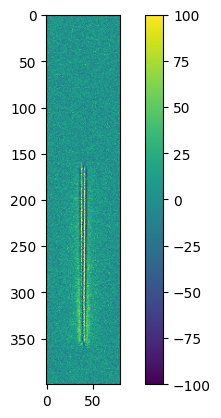

In [50]:
plt.imshow(data - X.dot(w).reshape(data.shape), vmin=-100, vmax=100)
plt.colorbar()

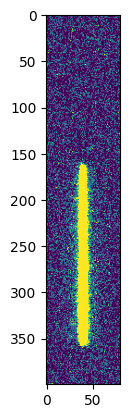

In [51]:
plt.imshow(data, vmin=0, vmax=40)

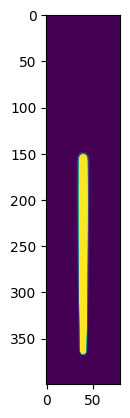

In [52]:
plt.imshow(pts.X.dot(amp2).reshape(data.shape), vmin=0, vmax=40)

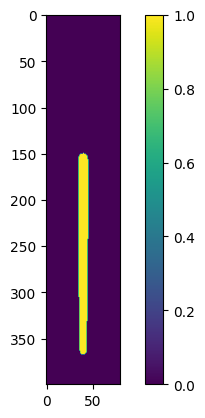

In [53]:
plt.imshow(pts.X.dot(amp2).reshape(data.shape) > 10)
plt.colorbar()